<a href="https://colab.research.google.com/github/pstjohn/gnn-codecamp/blob/main/cetane_number_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

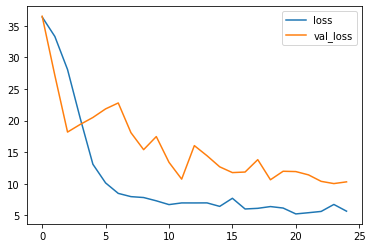

In [74]:
pd.DataFrame(hist.history).plot.line()

## Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [ ]:
%tensorflow_version 2.x
!pip install rdkit-pypi nfp

In [18]:
import numpy as np
import pandas as pd

import rdkit
from rdkit.Chem import AllChem

In [19]:
cn_data = pd.read_csv('https://raw.githubusercontent.com/pstjohn/gnn-codecamp/main/cn.csv')
cn_data.head()

,SMILES,IUPAC name,CN,Device
0,CCCCCCC,heptane,57.600,AFIDA
1,CCCCCCCCCCCCO,dodecan-1-ol,51.605,AFIDA
2,CCCC=O,butanal,38.315,AFIDA
3,CC1CCCCC1,methylcyclohexane,17.355,AFIDA
4,CC(C)CC(C)(C)C,"2,2,4-trimethylpentane",5.200,AFIDA


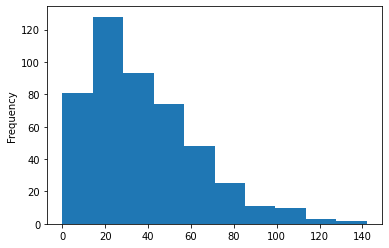

In [43]:
cn_data.CN.plot.hist()

In [45]:
cn_data['CN'] = cn_data.CN.clip(upper=100)

In [46]:
cn_test = cn_data.sample(frac=0.2, random_state=42)
cn_train = cn_data[~cn_data.index.isin(cn_test.index)]

In [36]:
def get_morgan_fingerprint(smiles, radius=2, nBits=1024):
  mol = rdkit.Chem.MolFromSmiles(smiles)
  bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
  return np.asarray(bv)

def get_all_fingerprints(smiles_series):
  fingerprints = np.vstack(smiles_series.apply(get_morgan_fingerprint).values)
  return fingerprints

In [38]:
fingerprints_train = get_all_fingerprints(cn_train.SMILES)
fingerprints_test = get_all_fingerprints(cn_test.SMILES)

In [39]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [62]:
input = tf.keras.layers.Input(shape=(1024), name='fingerprint', dtype='int64')
out = tf.keras.layers.Dense(128, activation='relu')(input)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(64, activation='relu')(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(1)(out)

mlp_model = tf.keras.Model(input, out)

In [63]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-2)
mlp_model.compile(optimizer=opt, loss='mae')

In [64]:
hist = mlp_model.fit(x=fingerprints_train, y=cn_train.CN,
                     validation_data=(fingerprints_test, cn_test.CN),
                     epochs=25, batch_size=32, verbose=2)

Epoch 1/25
12/12 - 1s - loss: 36.3978 - val_loss: 36.5176
Epoch 2/25
12/12 - 0s - loss: 33.3140 - val_loss: 27.1513
Epoch 3/25
12/12 - 0s - loss: 28.0816 - val_loss: 18.1742
Epoch 4/25
12/12 - 0s - loss: 20.3665 - val_loss: 19.3848
Epoch 5/25
12/12 - 0s - loss: 13.0791 - val_loss: 20.4843
Epoch 6/25
12/12 - 0s - loss: 10.1218 - val_loss: 21.8433
Epoch 7/25
12/12 - 0s - loss: 8.4632 - val_loss: 22.7834
Epoch 8/25
12/12 - 0s - loss: 7.9495 - val_loss: 18.0783
Epoch 9/25
12/12 - 0s - loss: 7.8062 - val_loss: 15.3870
Epoch 10/25
12/12 - 0s - loss: 7.2859 - val_loss: 17.4591
Epoch 11/25
12/12 - 0s - loss: 6.6862 - val_loss: 13.3861
Epoch 12/25
12/12 - 0s - loss: 6.9525 - val_loss: 10.7201
Epoch 13/25
12/12 - 0s - loss: 6.9497 - val_loss: 16.0271
Epoch 14/25
12/12 - 0s - loss: 6.9571 - val_loss: 14.4245
Epoch 15/25
12/12 - 0s - loss: 6.4047 - val_loss: 12.6694
Epoch 16/25
12/12 - 0s - loss: 7.6867 - val_loss: 11.7562
Epoch 17/25
12/12 - 0s - loss: 5.9935 - val_loss: 11.8451
Epoch 18/25
12/12

In [6]:
!pip install nfp